In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath(os.path.abspath("")))
scriptsdir = os.path.dirname(currentdir)
if scriptsdir not in sys.path:
    sys.path.append(scriptsdir)

from customscripts import configuration
from customscripts import utils

# Common imports
import numpy as np
import scipy as sp
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy import stats
from matplotlib import cm
from hmmlearn.hmm import GaussianHMM

formatter = ticker.FuncFormatter(utils.human_format)

So the data in this week have basically the structure as following:

Food
 - 1: Fruits and Vegetables
 - 2: Meat and Seafood
 - 3: Grains and Cereals
 - 4: Beverages
 - 5: Dairy

Industrial Product
 - 6: Minerals
 - 7: Base Metals
 - 8: Chemicals and Plastics
 - 9: Guns

In [2]:
# # get_dataset_df(weekNumber, datasetFileName)
# data = utils.get_dataset_df(4, "nutrition_unicef_cleaned")

# # first is the food data 
# data_food = utils.get_dataset_df(3, "all_categories") \
#     .drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Classification', 'Trade Flow Code', 'Reporter Code', \
#  'Reporter', 'Partner Code', 'Partner', 'Qty', 'Qty Unit', 'Qty Unit Code', 'Netweight (kg)', 'Category Code', 'Development Category', '% Malnutritioned Childern < 5 years old'])

# data_food = data_food.loc[data_food['Year'] >= 2007]
# data_food = data_food.loc[data_food['Trade Flow'] == 'Import']
# data_food['Year'] = data_food['Year'].astype(str)

# # then is the data of industrial product
# data_industrial = utils.get_dataset_df(4, "final") \
#     .drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Classification', 'Trade Flow Code', 'Reporter Code', \
#  'Reporter', 'Partner Code', 'Partner', 'Development Category']) 
# data_industrial = data_industrial.dropna(subset=['Year'])

# # remove the decimals in the column 'Year'
# data_industrial['Year'] = data_industrial['Year'].astype(int).astype(str)

So the month data contains the time interval of 11 years, from 2009-01 to 2019-12, with all data being imported trade value and also abort the category "Guns"

In [3]:
import zipfile

population_zip = zipfile.ZipFile(scriptsdir +'\dataset\week4.zip', 'r')
population_csv =population_zip.open('week4/population.csv')
data_population = pd.read_csv(population_csv)

month_zip = zipfile.ZipFile(scriptsdir +'\\dataset\\week6.zip', 'r')
month_csv = month_zip.open('week6/all_misc_data.csv')
# apply: data_misc["Time"] = pd.to_datetime(data_misc["Time"], format="%Y-%m-%d")
data_month = pd.read_csv(month_csv).drop(columns=['Unnamed: 0'])

Divide the trade value data by its population to get the per capita data, takes a bit long here, maybe there exist some more convenient methods?

In [3]:
# Initialization
data_month['Trade Value per capita'] = data_month['Trade Value (US$)']

month_sequence = sorted(data_month['Time'].unique().tolist())
years_sequence = ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
reporter_sequence = sorted(data_month['Reporter'].unique().tolist())
reporter_sequence[9] = 'DEU'

# implement the trade value per capita
for _, reporter in enumerate(reporter_sequence):
    # print(reporter) # for debugging
    for count, year in enumerate(years_sequence):
        data_month['Trade Value per capita'] = data_month['Trade Value per capita'] \
            .mask( (data_month['Reporter'] == reporter) & (data_month['Time'].isin(month_sequence[count*12: (count+1)*12]) ), \
                data_month['Trade Value (US$)'] / data_population.loc[data_population['Country Code'] == reporter][year].values )

In [4]:
# need to deal with GER/DEU separately since the name in two files are different
for count, year in enumerate(years_sequence):
    data_month['Trade Value per capita'] = data_month['Trade Value per capita'] \
        .mask( (data_month['Reporter'] == 'GER') & (data_month['Time'].isin(month_sequence[count*12: (count+1)*12]) ), \
            data_month['Trade Value (US$)'] / data_population.loc[data_population['Country Code'] == 'DEU'][year].values )

## Trade value per capita trend prediction for certain country, certain category


In [6]:
GER_data = data_month.loc[data_month['Reporter'] == 'GER'] \
    .groupby(['Time', 'Category Code']) \
    .agg(Trade_Value_per_Capita=("Trade Value per capita", "sum")) \
    .reset_index()
# for count, cate in enumerate(GER_data['Category Code'].unique().tolist()):
#     print(cate)
#     print(f"Min value from 2009 to 2019 is: {GER_data.loc[GER_data['Category Code'] == cate]['Trade_Value_per_Capita'].min()}" )
#     print(f"Max value from 2009 to 2019 is: {GER_data.loc[GER_data['Category Code'] == cate]['Trade_Value_per_Capita'].max()}")
#     print(f"Mean value from 2009 to 2019 is: {GER_data.loc[GER_data['Category Code'] == cate]['Trade_Value_per_Capita'].mean()}")
#     print(f"Std value from 2009 to 2019 is: {GER_data.loc[GER_data['Category Code'] == cate]['Trade_Value_per_Capita'].std()}")

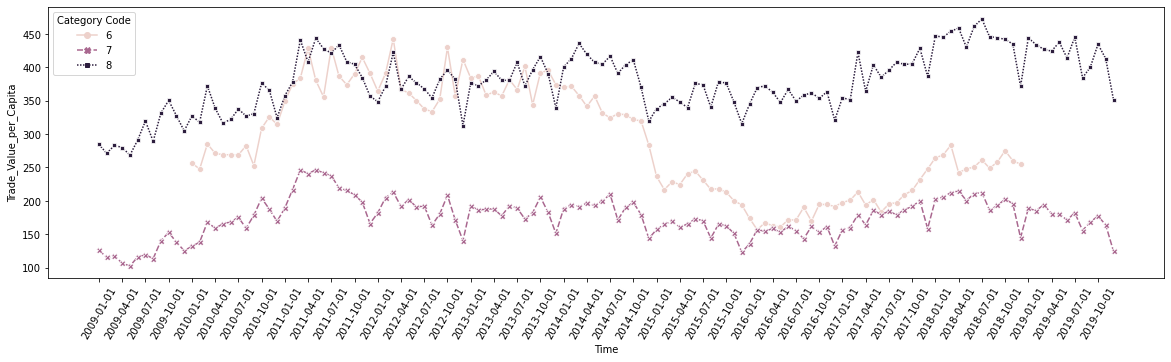

In [9]:
# Plot the example data for different categories
# Note that the Minerals trade begans at 2010
fig, ax = plt.subplots(figsize=(20,5));
sns.lineplot(x=GER_data['Time'].astype(str), y=GER_data['Trade_Value_per_Capita'], hue='Category Code', data=GER_data, ax=ax, markers=True, style='Category Code');

x_ticks = ax.get_xticks()[::3]
ax.set_xticks(x_ticks)
ax.xaxis.set_tick_params(rotation=60);

Now we use the HMM model in the hmmlearn library. Even though divide the trade value by the corresponding population, the line plot among countries in the same development level still varies a lot.

In [8]:
import warnings
warnings.filterwarnings("ignore")

# Brute force modelling
def get_best_hmm_model(X, max_states, max_iter = 10000):
    best_score = -(10 ** 10)
    best_state = 0
    
    for state in range(1, max_states + 1):
        hmm_model = GaussianHMM(n_components = state, random_state = 100, covariance_type = "diag", n_iter = max_iter).fit(X)
        print(f"HMM model with {state} states has score {hmm_model.score(X)}")
        if hmm_model.score(X) > best_score:
            best_score = hmm_model.score(X)
            best_state = state
    
    best_model = GaussianHMM(n_components = best_state, random_state = 100, covariance_type = "diag", n_iter = max_iter).fit(X)
    return best_model

# Normalized st. deviation
def std_normalized(vals):
    return np.std(vals) / np.mean(vals)

# moving average of the trade value
def ma(arr, window):
    x = arr.rolling(window = 1).mean()
    u = arr.rolling(window = window).mean()
    return (x-u)/x

# z-score
def zscore(arr, window):
    x = arr.rolling(window = 1).mean()
    u = arr.rolling(window = window).mean()
    o = arr.rolling(window = window).std()
    return (x-u)/o

In [9]:
def market_feature(future_period, moving_period, data):
    cols_features = ['Value Growth', 'Std Normalized', 'Value MA', 'Value Z-Score', 'Future Trend']

    # Create features
    data['Value Growth'] = data['Trade_Value_per_Capita'].pct_change()
    data['Std Normalized'] = data['Trade_Value_per_Capita'].rolling(moving_period).apply(std_normalized)

    data['Value MA'] = ma(data['Trade_Value_per_Capita'], moving_period)
    data['Value Z-Score'] = zscore(data['Trade_Value_per_Capita'], moving_period)

    data["Future Trend"] = data['Trade_Value_per_Capita'].pct_change(future_period).shift(-future_period)

    fig, axs = plt.subplots(1, len(cols_features), figsize = (16, 3));
    colours = cm.rainbow(np.linspace(0, 1, len(cols_features)));
    for i in range(0, len(cols_features)):
        axs[i].plot(data.reset_index()[cols_features[i]], color = colours[i]);
        axs[i].set_title(cols_features[i]);
        axs[i].grid(True);
    plt.tight_layout();

    return data

129

HMM model with 1 states has score 451.3442993304397
HMM model with 2 states has score 604.9712387764771
HMM model with 3 states has score 699.2628937914234
HMM model with 4 states has score 749.9295210164851
Best model with 4 states 


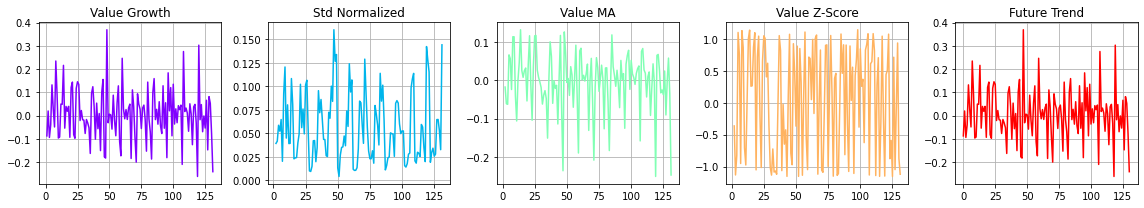

In [60]:
# Plot features
cols_features = ['Value Growth', 'Value MA', 'Value Z-Score', 'Future Trend']
GER_cate_data = GER_data.loc[GER_data['Category Code'] == 7]

move_period = 3
GER_cate_data = market_feature(1, move_period, GER_cate_data)

# use the data from, e.g. GER to train a corresponding HMM at first
train_idx = 132
train_set = GER_cate_data.dropna()[cols_features].values[:train_idx]
len(train_set)

GER_cate_model = get_best_hmm_model(X = train_set, max_states = 6, max_iter = 1000)
print("Best model with {0} states ".format(str(GER_cate_model.n_components)))

In the code above, we also created the "Future Trend" column that shifted by one lag for "Value Growth" perventage change, which allows us to understand how each state corresponds to the next price movement. And then the cumulative sum of "Future Trend" allows us to see the approximate future trend. This is the first key to understand the hidden states. Let’s plot this value as a cumulative sum by each state.

In [11]:
# General plots of hidden states
def plot_hidden_states(hmm_model, data, X, feature):

    fig, axs = plt.subplots(hmm_model.n_components, 3, figsize = (15, 10));
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components));
    hidden_states = hmm_model.predict(X);
    
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax[0].plot(data.index, data[feature], c = 'grey')
        ax[0].plot(data.index[mask], data[feature][mask], '.', c = 'r')
        ax[0].set_title("{0}th hidden state".format(i))
        # ax[0].xaxis.set_tick_params(rotation=90)
        ax[0].grid(True)

        ax[1].plot(data["Future Trend"][mask], '.', c='b')
        # ax[1].set_xlim([-0.1, 0.1])
        ax[1].set_title("Future Trend distrbution at {0}th hidden state".format(i))
        ax[1].grid(True)
        
        ax[2].plot(data["Future Trend"][mask].cumsum(), c = colour)
        ax[2].set_title("cumulative Future Trend at {0}th hidden state".format(i))
        ax[2].grid(True)
        
    plt.tight_layout();

Based on the locations of different hidden state, we can see that:
- state 0: is more likely to be some the some increasing states, namely, when current time step is in hidden state 0, we can find that for most point, the future trend is positive in second column, which means the next time step's trade value is going to increase;
- state 1: in contrast, the state 1 is more likely to be some the some decreasing states, namely, when current time step is in hidden state 0, then the next time step's trade value is going to decrease;
- state 2: more likely to be some top points, namely, the current trade value is going to be the largest compare with the time step before and after;
- state 3: some bottom points, this can be clearly see in the with the red points, which means the trade value is the minina compared to its neighborhood;
- still not very conclusive with monthly data over 10 years, maybe should get more data in the next week.

And trick with a cumulative sum of "futre trend" allows us to understand how each hidden state's total trde value trend among the whole time interval.

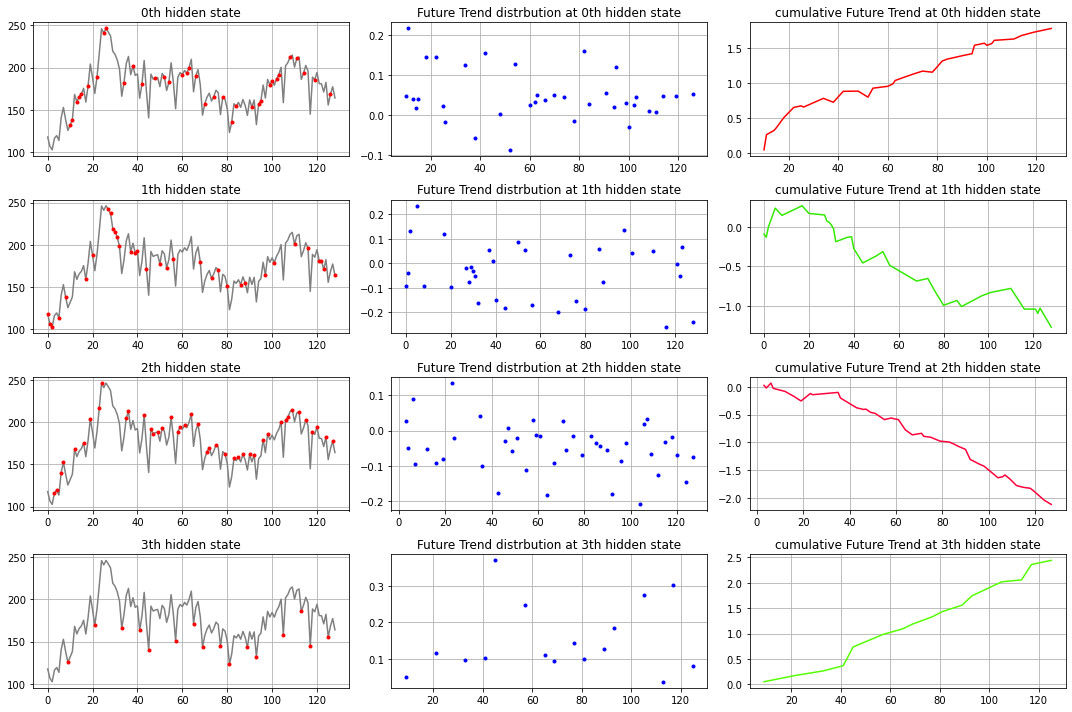

In [61]:
plot_hidden_states(GER_cate_model, GER_cate_data[move_period-1 :-1].reset_index(), train_set, 'Trade_Value_per_Capita')

In [62]:
# predict the next hidden state
state_sequence = GER_cate_model.predict(train_set)

prob_next_step = GER_cate_model.transmat_[state_sequence[-1], :]
prob_next_step

array([0.1853407 , 0.3063793 , 0.17745059, 0.33082941])

In the above training process, the data in stard and end interval is dropped since nan in corresponding features can not be used, the dropped size is decided by the moving period and the future period. Even with more time point, the model is still not conclusive enough. This should be eased when we have much more data point.

So the final result of 2019-12 hidden state is 4, which hints that the trade value in 2019-12 will go down to some bottom point, which is proved by the graph in the first figure.

The second key is to research each state by features. After that, we can relate these two events (future movement and current condition). Let's look at states and the next marker movement

In [63]:
def compare_hidden_states(hmm_model, cols_features, iters = 1000):
    
    fig, axs = plt.subplots(len(cols_features), hmm_model.n_components, figsize = (15, 10))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))
    
    for i in range(0, hmm_model.n_components):
        mc_df = pd.DataFrame()
    
        # Samples generation
        for j in range(0, iters):
            row = np.transpose(hmm_model._generate_sample_from_state(i))
            mc_df = mc_df.append(pd.DataFrame(row).T)
        mc_df.columns = cols_features
    
        for k in range(0, len(mc_df.columns)):
            axs[k][i].hist(mc_df[cols_features[k]], color = colours[i])
            axs[k][i].set_title(cols_features[k] + " (state " + str(i) + "): ")
            axs[k][i].grid(True)
            
    plt.tight_layout()

First we can be familiar with the concept here:

- Value Growth: can be understood as the percentage change of trade value in next time step with the current time step, so it allows us to forecast whether the next time trade value is going to increase or decrease. And we can see for state 0 and state 2 it's mainly 

- Moving Average: $ MA = 1 - \frac{mean \ value}{current \ value} $, so if positive, then it means the current value is mostly large than the mean value in the moving period, and we can see that in state 0&2 it is most positive, the just difference is that for state 0 the increasing amplitude is not very large(lower than 0.05), but for state 2 it's larger than 0.05;

- Z-Score
The interesting fact is: 
- state 0:
- state 1: the moving average 
- state 2: 
- state 3: always has a negative value growth, which means it's always in the downside direction. In contrast, state 2 mostly in upside direction.


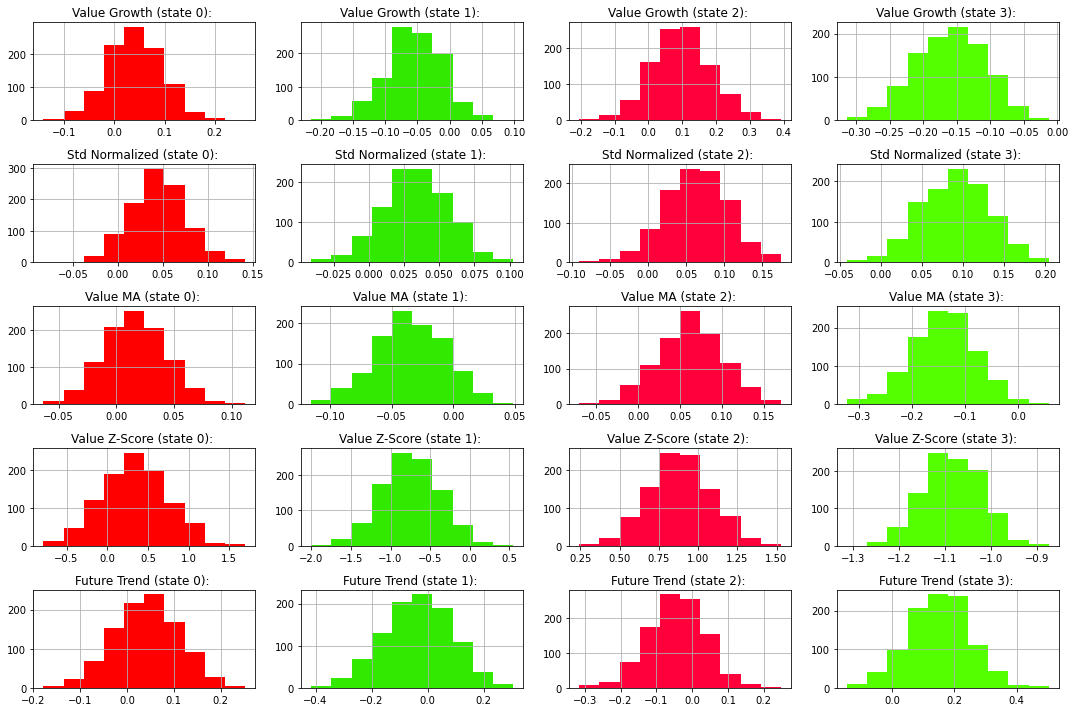

In [64]:
compare_hidden_states(GER_cate_model, cols_features=cols_features, iters=1000)